In [1]:
# Contrução de uma árvore de decisão onde o objetivo 
# é identificar quais os clientes de um determinado 
# banco são mais suscetíveis a realizar um deposito
# de longo prazo, utilizando dados das contas bancárias
# para criar um modelo de predição, a fim de guiar
# as novas campanhas de markting.
# 
# O código foi baseado no tutorial do site kaggle:
# https://www.kaggle.com/shirantha/bank-marketing-data-a-decision-tree-approach/data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn import datasets
from io import StringIO
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import metrics
%matplotlib inline

In [2]:
# Carrega Arquivo CSV
bank=pd.read_csv('bank.csv')
# Mostra Primeiras (5) Lisnhas do DataFrame "bank"
bank.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [3]:
# Confere se o data set contém algum valor nulo - Não foi achado valor nulo em nenhuma coluna.
bank[bank.isnull().any(axis=1)].count()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64

In [4]:
# Mostra alguns dados estatísticos do dataframe "bank"
bank.describe()

,age,balance,day,duration,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,1528.538524,15.658036,371.993818,2.508421,51.330407,0.832557
std,11.913369,3225.413326,8.420740,347.128386,2.722077,108.758282,2.292007
min,18.000000,-6847.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,122.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,550.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,49.000000,1708.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,95.000000,81204.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


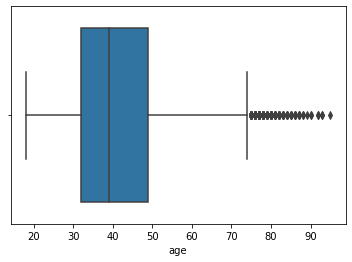

In [5]:
# Plota o gráfico Boxplot para coluna 'age'
g = sns.boxplot(x=bank["age"])

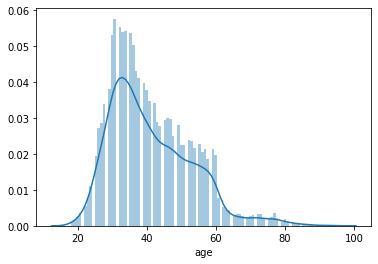

In [6]:
# Plota o gráfico de distribuição normal para coluna 'age'
sns.distplot(bank.age, bins=100)

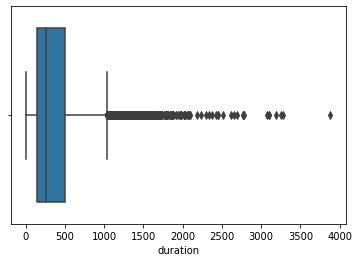

In [7]:
# Plota o gráfico Boxplot para coluna 'duration'
g = sns.boxplot(x=bank["duration"])

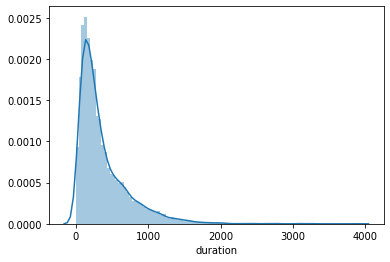

In [8]:
# Plota o gráfico de distribuição normal para coluna 'duration'
sns.distplot(bank.duration, bins=100)

In [9]:
# PRÉ-PROCESSAMENTO DOS DADOS

# Faz uma cópia de 'bank' para análises posteriores
bank_data = bank.copy()

In [10]:
# Armazena coluna 'bank_data["job"]' na nova matriz 'job'
job = bank_data["job"]
# Retorna os valores únicos da matriz 'job' e armazena em 'x'
x = np.unique(job)

In [11]:
# Contabiliza pessoas fizeram deposito em relação a cada categoria de emprego
jobs = x
for j in jobs:
    print("{:15} : {:5}". format(j, len(bank_data[(bank_data.deposit == "yes") & (bank_data.job ==j)])))

admin.          :   631
blue-collar     :   708
entrepreneur    :   123
housemaid       :   109
management      :  1301
retired         :   516
self-employed   :   187
services        :   369
student         :   269
technician      :   840
unemployed      :   202
unknown         :    34


In [12]:
# Mostra a quantidade de de ocorrências de cada diferente categoria de emprego dentro da coluna 'job'
bank_data.job.value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

In [13]:
# Troca o nome de categorias similares de empregos por um nome único
bank_data['job'] = bank_data['job'].replace(['management', 'admin.'], 'white-collar')
bank_data['job'] = bank_data['job'].replace(['services','housemaid'], 'pink-collar')
bank_data['job'] = bank_data['job'].replace(['retired', 'student', 'unemployed', 'unknown'], 'other')

In [14]:
# Mostra a quantidade de de ocorrências de cada diferente categoria de emprego dentro da coluna 'job', após mudança nos rótulos
bank_data.job.value_counts()

white-collar     3900
blue-collar      1944
technician       1823
other            1565
pink-collar      1197
self-employed     405
entrepreneur      328
Name: job, dtype: int64

In [15]:
# Mostra a quantidade de de ocorrências de cada diferente rótulo dentro da coluna 'poutcome'
bank_data.poutcome.value_counts()

unknown    8326
failure    1228
success    1071
other       537
Name: poutcome, dtype: int64

In [16]:
# Transforma itens categorizados como 'unknown' em 'other', dentro da coluna 'poutcome'
bank_data['poutcome'] = bank_data['poutcome'].replace(['other'] , 'unknown')
bank_data.poutcome.value_counts()

unknown    8863
failure    1228
success    1071
Name: poutcome, dtype: int64

In [17]:
# Remove a coluna 'contact', pois assume-se que ela não tem relevância para a análise
bank_data.drop('contact', axis=1, inplace=True)

In [18]:
# Cria uma nova coluna no dataframe chamada 'default_cat' e armazena nela os valores de 'default', trocando ['yes' por 1 , 'no' por 0]
bank_data['default_cat'] = bank_data['default'].map( {'yes':1, 'no':0} )
# Remove a coluna 'default'
bank_data.drop('default', axis=1,inplace = True)

In [19]:
# Cria uma nova coluna no dataframe chamada 'housing_cat' e armazena nela os valores de 'housing', trocando ['yes' por 1 , 'no' por 0]
bank_data["housing_cat"]=bank_data['housing'].map({'yes':1, 'no':0})
# Remove a coluna 'housing'
bank_data.drop('housing', axis=1,inplace = True)

In [20]:
# Cria uma nova coluna no dataframe chamada 'loan_cat' e armazena nela os valores de 'loan', trocando ['yes' por 1 , 'no' por 0]
bank_data["loan_cat"] = bank_data['loan'].map({'yes':1, 'no':0})
# Remove a coluna 'loan'
bank_data.drop('loan', axis=1, inplace=True)

In [21]:
# day  : Último dia do mês que o indivíduo acessou a conta bancária
# month: Último mês que o indivíduo acessou a conta bancária
# Remove do dataframe 'month' e 'day', como eles não tem nenhum significado intríseco
bank_data.drop('month', axis=1, inplace=True)
bank_data.drop('day', axis=1, inplace=True)

In [22]:
# Cria uma nova coluna no dataframe chamada 'deposit_cat' e armazena nela os valores de 'deposit', trocando ['yes' por 1 , 'no' por 0]
bank_data["deposit_cat"] = bank_data['deposit'].map({'yes':1, 'no':0})
# Remove a coluna 'deposit'
bank_data.drop('deposit', axis=1, inplace=True)

In [23]:
# pdays: Número de dias que passaram depois que o cliente foi contatado pela última vez de uma campanha de marketing anterior
#       -1 significa que o cliente nunca foi contactado numa campanha de marketing

print("Clientes que nunca foram contactados em campanhas de markting:", len(bank_data[bank_data.pdays==-1]))
# Identificando a quantidade máxima de dias que se passaram desde o último contato, para posteriormente definir o valor que será utilizado para normalizar 'pdays' 
print("Máximo valor em pdays   :", bank_data['pdays'].max())

Clientes que nunca foram contactados em campanhas de markting: 8324
Máximo valor em pdays   : 854


In [24]:
# Troca -1 por 10.000 dentro de 'pdays'
bank_data.loc[bank_data['pdays'] == -1, 'pdays'] = 10000


In [25]:
#  Cria 'recent_pdays' e armazena valores normalizados de 'pdays'
bank_data['recent_pdays'] = np.where(bank_data['pdays'], 1/bank_data.pdays, 1/bank_data.pdays)
# Remove 'pdays'
bank_data.drop('pdays', axis=1, inplace = True)

In [26]:
# Converte variáveis qualitativas em variáveis Dummy
bank_with_dummies = pd.get_dummies(data=bank_data, columns = ['job', 'marital', 'education', 'poutcome'], \
                                   prefix = ['job', 'marital', 'education', 'poutcome'])

# Mostra Primeiras (4) Lisnhas do DataFrame "bank"
bank_with_dummies.head(4)

,age,balance,duration,campaign,previous,default_cat,housing_cat,loan_cat,deposit_cat,recent_pdays,...,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,poutcome_failure,poutcome_success,poutcome_unknown
0,59,2343,1042,1,0,0,1,0,1,0.0001,...,0,1,0,0,1,0,0,0,0,1
1,56,45,1467,1,0,0,0,0,1,0.0001,...,0,1,0,0,1,0,0,0,0,1
2,41,1270,1389,1,0,0,1,0,1,0.0001,...,0,1,0,0,1,0,0,0,0,1
3,55,2476,579,1,0,0,1,0,1,0.0001,...,0,1,0,0,1,0,0,0,0,1


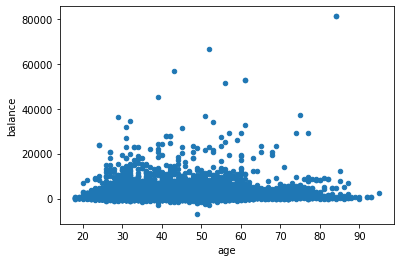

In [27]:
# Plota gráfico de dispersão entre as categorias 'age' e 'balance'
bank_with_dummies.plot(kind='scatter', x='age', y='balance');

# Em todas idades, a maioria das pessoas tem economias menores que 20.000 

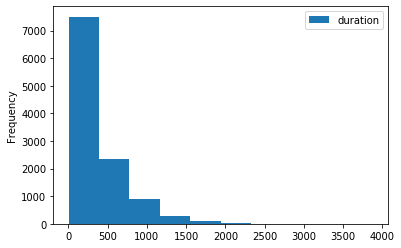

In [28]:
# Plota histograma entre as categorias 'poutcome_success' e 'duration'
bank_with_dummies.plot(kind='hist', x='poutcome_success', y='duration');

In [29]:
# Estatisticas das pessoas que fizeram um deposito de longo prazo
bank_with_dummies[bank_data.deposit_cat == 1].describe()

,age,balance,duration,campaign,previous,default_cat,housing_cat,loan_cat,deposit_cat,recent_pdays,...,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,poutcome_failure,poutcome_success,poutcome_unknown
count,5289.000000,5289.000000,5289.000000,5289.000000,5289.000000,5289.000000,5289.000000,5289.000000,5289.0,5289.000000,...,5289.000000,5289.000000,5289.000000,5289.000000,5289.000000,5289.000000,5289.000000,5289.000000,5289.000000,5289.000000
mean,41.670070,1804.267915,537.294574,2.141047,1.170354,0.009832,0.365854,0.091511,1.0,0.004238,...,0.117603,0.520892,0.361505,0.111741,0.463226,0.377387,0.047646,0.116846,0.184912,0.698242
std,13.497781,3501.104777,392.525262,1.921826,2.553272,0.098676,0.481714,0.288361,0.0,0.035686,...,0.322167,0.499611,0.480482,0.315078,0.498693,0.484779,0.213036,0.321267,0.388263,0.459064
min,18.000000,-3058.000000,8.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000100,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,31.000000,210.000000,244.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000100,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,38.000000,733.000000,426.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000100,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,50.000000,2159.000000,725.000000,3.000000,1.000000,0.000000,1.000000,0.000000,1.0,0.005128,...,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,95.000000,81204.000000,3881.000000,32.000000,58.000000,1.000000,1.000000,1.000000,1.0,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [30]:
# Pessoas que se inscreveram para um termo de depósito com um empréstimo pessoal (loan_cat) e empréstimo à habitação (housing_cat)
len(bank_with_dummies[(bank_with_dummies.deposit_cat == 1) & (bank_with_dummies.loan_cat) & (bank_with_dummies.housing_cat)])

265

In [31]:
# Pessoas que se inscreveram para um termo de depósito com inadimplência de crédito
len(bank_with_dummies[(bank_with_dummies.deposit_cat == 1) & (bank_with_dummies.default_cat ==1)])

52

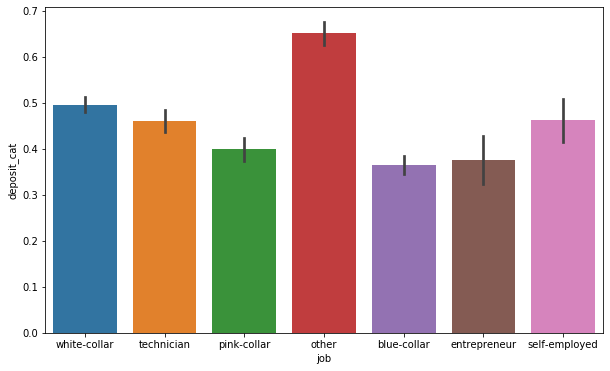

In [32]:
# Gráfico de barras para 'job' Vs 'deposite'
plt.figure(figsize = (10,6))
sns.barplot(x='job', y = 'deposit_cat', data = bank_data)

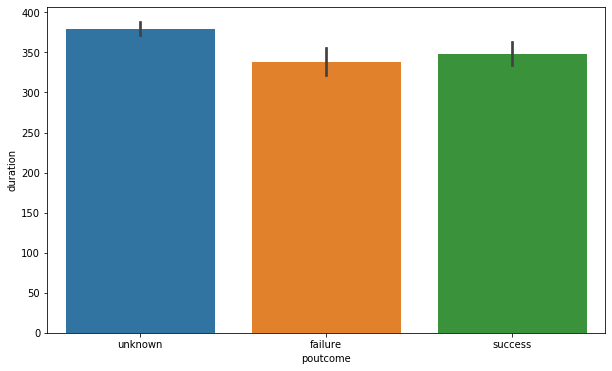

In [33]:
# Gráfico de barras para  "previous outcome" Vs "call duration"
plt.figure(figsize = (10,6))
sns.barplot(x='poutcome', y = 'duration', data = bank_data)


In [34]:
# Copiando 'bank_with_dummies' em 'bankcl', para separar os dados posteriormente
bankcl = bank_with_dummies

In [35]:
# Cria Matriz de Correlação (Medida de relação entre duas variáveis - Quanto mais perto de 1.000 mais a variável se relaciona com a outra)
corr = bankcl.corr()

Text(0.5, 1, 'Heatmap of Correlation Matrix')

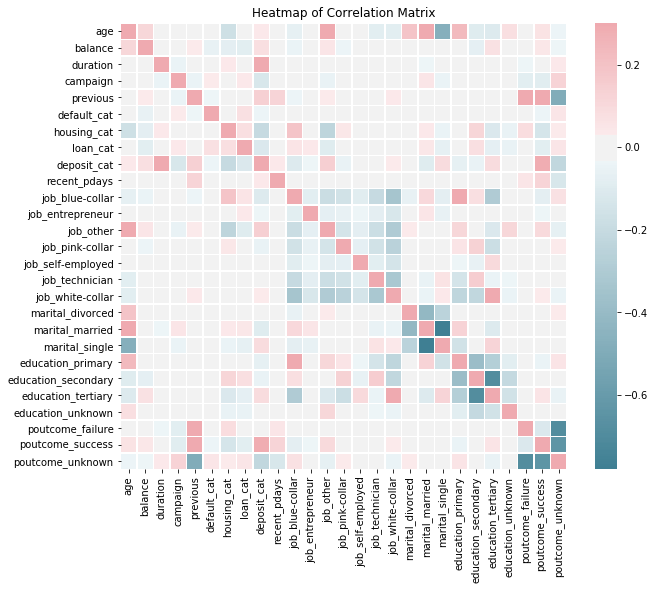

In [36]:
# Plota mapa de calor da matriz correlacional
plt.figure(figsize = (10,10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .82})
plt.title('Heatmap of Correlation Matrix')

In [37]:
# Extraia a coluna 'deposit_cat' (variável dependente)
corr_deposite = pd.DataFrame(corr['deposit_cat'].drop('deposit_cat'))
# Ordena as categorias dentro de 'corr_deposite' em relação aos respectivos valores, em ordem decrescente
corr_deposite.sort_values(by = 'deposit_cat', ascending = False)

,deposit_cat
duration,0.451919
poutcome_success,0.286642
job_other,0.144408
previous,0.139867
marital_single,0.094632
education_tertiary,0.094598
balance,0.081129
age,0.034901
recent_pdays,0.034457
job_white-collar,0.031621


In [38]:
# Remove 'deposit_cat' e armazena em 'data_drop_deposite' -> Separação dos dados de entrada no modelo
data_drop_deposite = bankcl.drop('deposit_cat', 1)

# Armazena em 'output' a coluna 'deposit_cat' -> Separação dos dados de saída do modelo(Deposito['1' para Sim, '0' para Não])
output = bankcl.deposit_cat

# Separação entre dados Treinamento/Teste : 20% serão dados de Teste
data_train, data_test, output_train, output_test = train_test_split(data_drop_deposite, output, test_size = 0.2, random_state = 50)

In [39]:
# Define árvore de decisão de profundidade 2, em 'decision_Tree_D2'
decision_Tree_D2 = tree.DecisionTreeClassifier(random_state=1, max_depth=2)

# Treina árvore de decisão com os dados de treinamento 
decision_Tree_D2.fit(data_train, output_train)

# Cálcula a precisão da árvore com os dados de treinamento
decision_Tree_D2_score_train = decision_Tree_D2.score(data_train, output_train)

# Cálcula a precisão da árvore com os dados de teste
decision_Tree_D2_score_test = decision_Tree_D2.score(data_test, output_test)

print("Training score: ",decision_Tree_D2_score_train)

print("Testing score: ",decision_Tree_D2_score_test)

Training score:  0.7285250307985217
Testing score:  0.7268248992386923


In [40]:
# Define árvore de decisão de profundidade 3, em 'decision_Tree_D3'
decision_Tree_D3 = tree.DecisionTreeClassifier(random_state=1, max_depth=3)

# Treina árvore de decisão com os dados de treinamento 
decision_Tree_D3.fit(data_train, output_train)

# Cálcula a precisão da árvore com os dados de treinamento
decision_Tree_D3_score_train = decision_Tree_D3.score(data_train, output_train)

# Cálcula a precisão da árvore com os dados de teste
decision_Tree_D3_score_test = decision_Tree_D3.score(data_test, output_test)

print("Training score: ",decision_Tree_D3_score_train)

print("Testing score: ",decision_Tree_D3_score_test)

Training score:  0.770411020271027
Testing score:  0.7572772055530677


In [41]:
# Define árvore de decisão de profundidade 4, em 'decision_Tree_D4'
decision_Tree_D4 = tree.DecisionTreeClassifier(random_state=1, max_depth=4)

# Treina árvore de decisão com os dados de treinamento 
decision_Tree_D4.fit(data_train, output_train)

# Cálcula a precisão da árvore com os dados de treinamento
decision_Tree_D4_score_train = decision_Tree_D4.score(data_train, output_train)

# Cálcula a precisão da árvore com os dados de teste
decision_Tree_D4_score_test = decision_Tree_D4.score(data_test, output_test)

print("Training score: ",decision_Tree_D4_score_train)

print("Testing score: ",decision_Tree_D4_score_test)

Training score:  0.7885541494008288
Testing score:  0.774294670846395


In [42]:
# Define árvore de decisão de profundidade 7, em 'decision_Tree_D7'
decision_Tree_D7 = tree.DecisionTreeClassifier(random_state=1, max_depth=7)

# Treina árvore de decisão com os dados de treinamento 
decision_Tree_D7.fit(data_train, output_train)

# Cálcula a precisão da árvore com os dados de treinamento
decision_Tree_D7_score_train = decision_Tree_D7.score(data_train, output_train)

# Cálcula a precisão da árvore com os dados de teste
decision_Tree_D7_score_test = decision_Tree_D7.score(data_test, output_test)

print("Training score: ",decision_Tree_D7_score_train)

print("Testing score: ",decision_Tree_D7_score_test)

Training score:  0.8200246388173368
Testing score:  0.7854903716972682


In [43]:
# Define árvore de decisão de profundidade 10, em 'decision_Tree_D10'
decision_Tree_D10 = tree.DecisionTreeClassifier(random_state=1, max_depth=10)

# Treina árvore de decisão com os dados de treinamento 
decision_Tree_D10.fit(data_train, output_train)

# Cálcula a precisão da árvore com os dados de treinamento
decision_Tree_D10_score_train = decision_Tree_D10.score(data_train, output_train)

# Cálcula a precisão da árvore com os dados de teste
decision_Tree_D10_score_test = decision_Tree_D10.score(data_test, output_test)

print("Training score: ",decision_Tree_D10_score_train)

print("Testing score: ",decision_Tree_D10_score_test)

Training score:  0.8605666927987456
Testing score:  0.7850425436632333
